# INFS770
## Assignment 2
### Kevin Kuipers 
#### 3/17/2020

##### The objective of this notebook is implement a recommender system using a book rating data set. I will begin by loading some libraries that will be helpful: pandas, numpy, and some functions for cosine distance, uclidean distance, and correlation distance.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean

### Importing the data

In [2]:
df = pd.read_csv('C:/Users/Agent000/Documents/DSU/Classes/2020/Spring 2020/Assignments/Assignment 2/DBbook_train_ratings.tsv',
    sep='\t',
    header=0)

In [3]:
df.head()

,userID,itemID,rate
0,6873,3201,4
1,6873,3098,4
2,6873,4198,4
3,6873,5950,4
4,6873,204,4


##### Looking at the first five rows of the data User ID is the first column which refers to the user. ItemID is the book. And rate is the value the user rated the book. 

# Q1 
##### Now lets look at the number of unique users and the number of unique books in the entire data set

In [4]:
print("Unique users: %d" % len(df['userID'].unique()))
print('Unique books: %d' % len(df['itemID'].unique()))

Unique users: 6181
Unique books: 6166


# Q2

##### Now I will create utility matrix. Each row of this matrix represents a user, and the columns represent an item. After creating it I will output the first 10 rows and to see what it looks. then I will count the number of cells that contain NaN. This output will tell the number of cells that are not populated. I will create a percentage of the data set to see how many contain NaN.  Lastly, for this section I will populate all missing values with 0.

In [5]:
dense_matrix = df.pivot_table(values='rate', index=['userID'], columns=['itemID'])

print('The shape of the user-item matrix: %d x %d' % dense_matrix.shape)
print(dense_matrix.head(10))

The shape of the user-item matrix: 6181 x 6166
itemID  1     2     3     5     7     8     9     11    12    13    ...  8157  \
userID                                                              ...         
1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
6        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
7        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
8        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
10       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

In [6]:
print("The number of non-populated cells (containing NaN): %d" % np.count_nonzero(~np.isnan(dense_matrix)))

percentage = (np.count_nonzero(~np.isnan(dense_matrix)))/(6181*6166)
percentage = percentage*100

print("the percentage of cells in the utility matrix that are not populated:",percentage,"%")



The number of non-populated cells (containing NaN): 75558
the percentage of cells in the utility matrix that are not populated: 0.19825227960734515 %


In [7]:
dense_matrix = dense_matrix.fillna(0)
dense_matrix.head()

itemID,1,2,3,5,7,8,9,11,12,13,...,8157,8160,8161,8162,8163,8164,8166,8167,8168,8169
userID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### As you can see the NaN values have been replaced with 0s. Lets look at the distribution of rattings

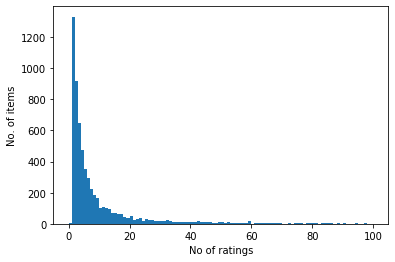

In [8]:
%matplotlib inline


ri = dense_matrix.apply(np.count_nonzero, axis=0)
import matplotlib.pyplot as plt
plt.hist(ri.values, bins=100, range=(0,100))
plt.ylabel('No. of items')
plt.xlabel('No of ratings')
plt.show()

##### It looks like we are dealing we a skewed distribution. Most users are do not rate every single item. it looks between 0 and 10 is the majority of the data. Lets take a look at the average number fo ratings per user. 

The Average number of ratings per user is : 12.196570134282478


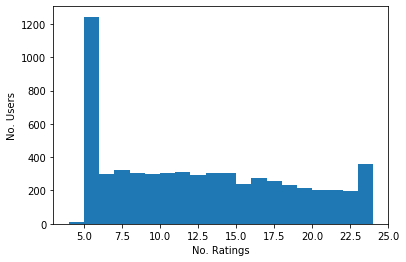

In [9]:
ri2 = dense_matrix.apply(np.count_nonzero, axis=1)
print("The Average number of ratings per user is :", sum(ri2)/float(len(ri2)))

plt.hist(ri2.values, bins=20)
plt.ylabel('No. Users')
plt.xlabel('No. Ratings')
plt.show()

# Q3

##### Now I will write code to print the top 5 similar users to userID 2 based on Euclidean distance. This will be done by creating a function to plug in any userID to find the top similar users.

In [10]:
def top_n_users(userno, n):
    
    df_sim = dense_matrix.loc[dense_matrix.index != userno]
    
    df_sim['distance'] = df_sim.apply(lambda x: euclidean(dense_matrix.loc[userno], x), axis=1)
    
    return df_sim.sort_values(by='distance').head(n)['distance']

In [11]:
top_n_users(2,5)

C:\Users\Agent000\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


userID
3917    11.401754
6875    12.569805
986     12.806248
1983    12.884099
1156    12.922848
Name: distance, dtype: float64

# Q4

##### I want to compare what it more like item 1. Is it item 18 or item 36? To determine which item is more like item 1, I will use euclidean distance between 18 and 1, and 36 and 1. The smaller the distance between the two will reveal whether 18 or 36 is more similar to 1. Each item is a vector and the shorter the distance between 18 and 1 & 36 and 1 reveals that the weights in the vector are closer to the same in 1. 

In [12]:
eight = euclidean(dense_matrix[18], dense_matrix[1])
thirty = euclidean(dense_matrix[36], dense_matrix[1])
print("Euclidean distance between item 18 and 1:", eight)
print("Euclidean distance between item 36 and 1:", thirty)


Euclidean distance between item 18 and 1: 29.189039038652847
Euclidean distance between item 36 and 1: 40.124805295477756


In [13]:
print("itemID 18 is more similar to itemID 1 than itemID 36 because the distance is much shorter between these two vectors.")

itemID 18 is more similar to itemID 1 than itemID 36 because the distance is much shorter between these two vectors.


# Q5

##### The previous definition was created to look at similar users given a userID. Now I will create a definition to find the top 5 items that are most similar to a given itemID. 

In [14]:
def top_n_items(item_no, n):
    df_sim = dense_matrix.transpose()
    df_sim = df_sim.loc[df_sim.index != item_no]
    df_sim['distance'] = df_sim.apply(lambda x: euclidean(dense_matrix[item_no], x), axis=1)
    return df_sim.sort_values(by='distance').head(n)['distance']

In [15]:
top_n_items(8010, 5)

itemID
3711    127.921851
4559    127.964839
330     129.715072
1311    129.722781
7328    129.761319
Name: distance, dtype: float64

# Q6

##### Now I will remove books and users with less than 20 ratings per scores from the utility matrix. After this has been done I will out the matrix shape to see how much it has changed

In [16]:
df_i_f = df.groupby('itemID').count()
df_u_f = df.groupby('userID').count()
items = df_i_f[df_i_f['userID']>20].index
dense_matrix = dense_matrix[items]
users = df_u_f[df_u_f['itemID']>20].index
dense_matrix = dense_matrix.loc[users]

print("The shape of dense matrix is now : %d x %d" % dense_matrix.shape)

The shape of dense matrix is now : 766 x 776


##### Since many data points have been removed lets look to see how much the average number of rating per user has changed. I will also output the histogram just to see how it looks. 

The average number of ratings per user is : 14.212793733681462


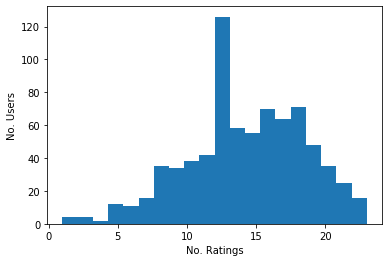

In [17]:
ri3 = dense_matrix.apply(np.count_nonzero, axis=1)
print("The average number of ratings per user is :", sum(ri3)/float(len(ri3)))

plt.hist(ri3, bins=20)
plt.ylabel('No. Users')
plt.xlabel('No. Ratings')
plt.show()

# Q7

##### Now lets remove users who have not rated itemID 8010. Previously, the value 0 was supplemented for users and items that have not been rated. Therefore, any user that has a 0 for itemID will be removed. Before doing this lets look at the count of the different ratings before removing. Then after removing those users I will look at the counts. 

In [18]:
#Outputing the counts for itemID 8010 before removing it from the matrix
print(dense_matrix[8010].value_counts())

#removing users who did not rate itemID 8010 from the matrix
dense_matrix = dense_matrix[dense_matrix[8010]>0]

0.0    592
4.0     68
5.0     58
3.0     27
2.0     13
1.0      8
Name: 8010, dtype: int64


In [19]:
#Looking at the first five rows of the matrix after removing users who did not rate itemID 8010
dense_matrix.head()

itemID,1,3,18,36,37,39,43,45,48,49,...,8054,8072,8073,8088,8098,8120,8125,8163,8168,8169
userID,,,,,,,,,,,,,,,,,,,,,
175,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Looking at the shape of the matrix after removing the users who did not rate itemID 8010
print("The shape of dense matrix is now : %d x %d" % dense_matrix.shape)

The shape of dense matrix is now : 174 x 776


In [21]:
#Looking the coutns of the ratings for itemID 8010 after removing the users who did not rate this item
dense_matrix[8010].value_counts()

4.0    68
5.0    58
3.0    27
2.0    13
1.0     8
Name: 8010, dtype: int64

##### The number of users have been greatly reduced. It looks like 174 users have actually rates itemID 8010. 

# Q8

##### The data remaining data set will be split between 25% of users for testing the other 75% will be used for training. Along the way I will print the dimensions of the test set and training set. I will also print the mean rating of itemID 8010 in the training set and testing set. This means the itemID 8010 is the target variable and all the columns/ItemIDs are the features. 

### Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split

#Grabbing all the itemIDs that are not 8010
X = dense_matrix[dense_matrix[8010]!=0]

#Grabbing the specific target variable which in this case is itemID 8010
y = dense_matrix[8010]

#train-test split. 25% will be testing and 75% will be training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 725)

### Dimensions of Training and Testing Set

In [23]:
#For the x_train and x_test dimensions
print("The dimensions of the training set excluding itemID 8010 : %d x %d" % np.shape(x_train))
print("The dimensions of the test set excluding itemID 8010 : %d x %d" % np.shape(x_test))


The dimensions of the training set excluding itemID 8010 : 130 x 776
The dimensions of the test set excluding itemID 8010 : 44 x 776


In [24]:
#Dimensions for the y_train and y_test
print("The dimensions of the training set for itemID 8010 : %d" % np.shape(y_train))
print("The dimensions of the test set itemID 8010 : %d" % np.shape(y_test))

The dimensions of the training set for itemID 8010 : 130
The dimensions of the test set itemID 8010 : 44


### Mean rating for itemID 8010 in training and testing set

In [25]:
print("The mean rating for itemID 8010 in training set is : %d", y_train.mean())
print("The mean rating for itemID 8010 in the testing set is : %d", y_test.mean())

The mean rating for itemID 8010 in training set is : %d 3.830769230769231
The mean rating for itemID 8010 in the testing set is : %d 4.068181818181818


##### It appears the mean rating for itemID 8010 is around 0.2 difference between the training and testing set

# Q9

##### This part will be subdivided into different sections. First I will print the userID of the user in the 5th row (Not userID 5) in the test data set. Second, I will predict this user's rating of itemID 8010 based on the top 5 similar users in the training data set. I will print the user's predicted rating and the actual rating of the book. When computing the distance and predicting the distance between the individual user I will look at euclidean and consine distance to see which one gets closer to the actual result for the 5th user for itemID 8010

### userID in the 5th row in the test set

In [26]:
print("The userID in the 5th row in the test set is : %d" % y_test.index[4])

The userID in the 5th row in the test set is : 1700


### Creating a function for user-based prediction

##### Before doing this I will need to convert the training and testing to data frames

In [27]:
df_x_train = pd.DataFrame(x_train)
df_x_test = pd.DataFrame(x_test)
df_y_test = pd.DataFrame(y_test)
df_y_train = pd.DataFrame(y_train)

print("shapes")
print(df_x_train.shape)
print(df_x_test.shape)
print(df_y_train.shape)
print(df_y_test.shape)

print()

print("class counts")
print(df_y_train[8010].value_counts())
print(df_y_test[8010].value_counts())

shapes
(130, 776)
(44, 776)
(130, 1)
(44, 1)

class counts
4.0    53
5.0    39
3.0    21
2.0    11
1.0     6
Name: 8010, dtype: int64
5.0    19
4.0    15
3.0     6
2.0     2
1.0     2
Name: 8010, dtype: int64


### Cosine distance function

In [28]:
n = 5

def user_based_predict_cosine(user_no):
    # retrive the top k similar users
    #copy from all the training predictors
    df_sim = df_x_train.copy()
    #for each user, calculate the distance between this user and the active user
    df_sim['distance'] = df_sim.apply(lambda x: cosine(df_x_test.loc[user_no], x), axis=1)
    #create a new date frame to store the top k similar users
    df_sim_users = df_sim.loc[df_sim.sort_values(by='distance').head(n).index]
    #calculate these similar users' rating on 8010, weighted by distance
    df_sim_users['weighted_d'] = list(map(lambda x: df_sim_users.loc[x]['distance']*df_y_train.loc[x][8010], df_sim_users.index))
    predicted = df_sim_users['weighted_d'].sum()/df_sim_users['distance'].sum()
    return predicted

### Euclidean distance function

In [29]:
k = 5

def user_based_predict_euclidean(user_no):
    # retrive the top k similar users
    #copy from all the training predictors
    df_sim = df_x_train.copy()
    #for each user, calculate the distance between this user and the active user
    df_sim['distance'] = df_sim.apply(lambda x: euclidean(df_x_test.loc[user_no], x), axis=1)
    #create a new date frame to store the top k similar users
    df_sim_users = df_sim.loc[df_sim.sort_values(by='distance').head(k).index]
    #calculate these similar users' rating on 8010, weighted by distance
    df_sim_users['weighted_d'] = list(map(lambda x: df_sim_users.loc[x]['distance']*df_y_train.loc[x][8010], df_sim_users.index))
    predicted = df_sim_users['weighted_d'].sum()/df_sim_users['distance'].sum()
    return predicted

In [30]:
print(df_x_test.head())

itemID  1     3     18    36    37    39    43    45    48    49    ...  8054  \
userID                                                              ...         
5703     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
5991     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6988     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3990     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1700     0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   0.0   

itemID  8072  8073  8088  8098  8120  8125  8163  8168  8169  
userID                                                        
5703     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5991     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6988     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3990     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1700     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [31]:
uid = df_x_test.index[4]
print(uid)
print("This users's rating on other items: ", df_x_test.loc[uid])
print()
print("The predicted rating on itemID 8010 using cosine distance: ", user_based_predict_cosine(uid))
print("The predicted rating on itemID 8010 using euclidean distance: ", user_based_predict_euclidean(uid))
print("The actual rating on itemID 8010: ", df_y_test.loc[uid][8010])

1700
This users's rating on other items:  itemID
1       0.0
3       0.0
18      0.0
36      0.0
37      0.0
39      1.0
43      0.0
45      0.0
48      0.0
49      0.0
58      0.0
59      0.0
60      0.0
77      0.0
81      0.0
84      0.0
87      0.0
110     0.0
111     0.0
114     0.0
117     0.0
123     0.0
137     0.0
138     0.0
139     0.0
143     0.0
144     0.0
146     0.0
147     0.0
148     0.0
       ... 
7682    0.0
7683    0.0
7689    0.0
7772    0.0
7783    0.0
7791    0.0
7792    0.0
7794    0.0
7795    0.0
7796    0.0
7800    0.0
7807    0.0
7867    0.0
7868    0.0
7891    0.0
7948    0.0
7951    0.0
8010    5.0
8016    0.0
8017    0.0
8054    0.0
8072    0.0
8073    0.0
8088    0.0
8098    0.0
8120    0.0
8125    0.0
8163    0.0
8168    0.0
8169    0.0
Name: 1700, Length: 776, dtype: float64

The predicted rating on itemID 8010 using cosine distance:  4.567684858569868
The predicted rating on itemID 8010 using euclidean distance:  4.181940146215447
The actual rating o

##### It appears the cosine distance did a better job predicting the actual rating on itemID 8010 for the 5th row user. If you follow the convential rules for rounding, the cosine distance would have been around up to 5.0 which is the actual rating for itemID for userID 1700 (5th row user). Whereas the eclidean distance would have been rounded down the 4.0, which is not actual rating for this user. 

# Q10

##### Content based filtering is a type of recommender system based on content. It builds upon the user's profile and recommends items based on the user's ratings or previously bought items. It takes the positve ratings from the user and compares to items that similar and then outputs those similar items to the user. 

##### Collaborative Filtering is the idea of combining both the user's preference and finding other users within the same community that have similar preferences. The individual user will receive recommendations based on other similar users with similar preference. The recommended items to the individual user are ones that have not been rated by the individual. There are two different approaches. User based approach: is making recommendations based on other users similar to the individual. Item based apporach: is making recommendatios based on similarity between items from other users ratings. 

##### Content based filtering is based solely on the individual user's preferences and finds other items similar to that preference. In contrast, collaborative filtering can create a hybrid model that incorporates both item based and user based filtering which takes into other users who are similar to the individual user. Therefore, incorporates the inidividual user's own preference and compares it to other users. Content based filtering uses an engine of objects and associates its to similar ones. Collaborative filtering uses an engine that links to others users data and associates similar preferences and makes assumptions based on either or both item or user preference to recommend items.   

#  Q11